# Pseudoproxy experiments with LMR and PAGES2k

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd

## Create a reconstruction job object

In [2]:
job = cfr.ReconJob(verbose=True)
print(job)

>>> job.configs:
{}


## Load a proxy database

In [3]:
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
# fig, ax = job.proxydb.plot(plot_count=True)
job.proxydb.plotly()

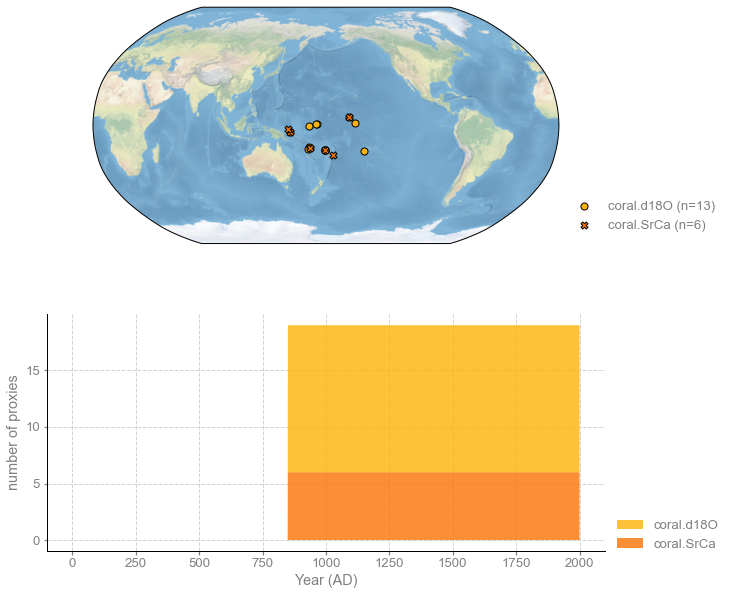

In [4]:
job.proxydb = job.proxydb.filter(by='loc-square', keys=(-20, 20, 150, 250))
fig, ax = job.proxydb.plot(plot_count=True)

## Load climate model priors

In [5]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas'] loaded
>>> job.prior created


In [6]:
job.obs = job.prior.copy()

In [7]:
# note that the lon axis has been wrapped into the 0-360 range
job.obs['tas'].da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
array([[[-1.0636749 , -1.0294495 , -1.3492584 , ..., -1.0242157 ,
         -1.0635376 , -1.4138641 ],
        [-1.1540222 , -1.2163696 , -0.829895  , ..., -1.1267395 ,
         -1.3661499 , -0.90708923],
        [-1.4681091 , -1.602951  , -1.3450012 , ..., -1.1113586 ,
         -1.5693207 , -0.92167664],
        ...,
        [ 6.3481445 ,  6.394562  ,  6.4255676 , ...,  6.1161804 ,
          6.219452  ,  6.2872467 ],
        [ 6.009857  ,  6.0487213 ,  6.065857  , ...,  5.7316437 ,
          5.839905  ,  5.9315186 ],
        [ 4.90889   ,  4.8928375 ,  4.8806915 , ...,  4.8749847 ,
          4.9002075 ,  4.917099  ]],

       [[-0.49842834, -0.5946655 , -0.6591644 , ..., -0.5899658 ,
         -0.5019989 , -0.7044983 ],
        [ 0.10722351,  0.06121826,  0.26878357, ...,  0.19108582,
          0.05096436,  0.28256226],
        [ 0.6283722 ,  0.4881897 ,  0.51179504, ...,  1.1141815 ,
          0.77900696,  0.9803467 ],
...
        [ 6.726837  ,  6.765442  ,  6.7901154 , ...,  6.5657654 ,
          6.61557   ,  6.6706543 ],
        [ 5.6950226 ,  5.674408  ,  5.631592  , ...,  5.676483  ,
          5.6833496 ,  5.6900024 ],
        [ 5.2715454 ,  5.2564087 ,  5.237488  , ...,  5.313385  ,
          5.299469  ,  5.2854004 ]],

       [[ 1.4049835 ,  1.326477  ,  1.3833313 , ...,  1.3267365 ,
          1.4027405 ,  1.376297  ],
        [ 1.2693939 ,  1.272644  ,  1.3366699 , ...,  1.3098145 ,
          1.3409729 ,  1.3334198 ],
        [ 1.4039001 ,  1.3622742 ,  1.3712463 , ...,  1.3796844 ,
          1.412674  ,  1.458786  ],
        ...,
        [ 2.1017456 ,  1.9748383 ,  1.903305  , ...,  2.144104  ,
          2.1205597 ,  2.1373749 ],
        [ 1.6789398 ,  1.6425476 ,  1.5784302 , ...,  1.6797638 ,
          1.6881409 ,  1.688797  ],
        [ 1.3906097 ,  1.3677521 ,  1.3432922 , ...,  1.4180145 ,
          1.4152832 ,  1.4091644 ]]], dtype=float32)
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

## Calibrate the PSMs

In [8]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
}
ptype_season_dict = {
    'coral.d18O': list(range(1, 13)),
    'coral.SrCa': list(range(1, 13)),
}
job.calib_psms(ptype_psm_dict=ptype_psm_dict, ptype_season_dict=ptype_season_dict, verbose=True)

>>> job.configs["ptype_psm_dict"] = {'coral.d18O': 'Linear', 'coral.SrCa': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
>>> job.configs["psm_calib_period"] = [1850, 2015]


Calibrating the PSMs: 100%|██████████| 19/19 [00:03<00:00,  6.04it/s]

>>> 19 records tagged "calibrated" with ProxyRecord.psm created


In [9]:
# check the fitting R-squared
print(job.proxydb.records['Ocn_098'].psm.calib_details['fitR2adj'])

# check the obs err matrix
print(job.proxydb.records['Ocn_098'].R)

0.989928716533919
0.00601109321422648


## Forward the PSMs

In [10]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 19/19 [00:03<00:00,  6.28it/s]

>>> ProxyRecord.pseudo created for 19 records


## Annualize/seasonalize the climate model prior

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.prior updated


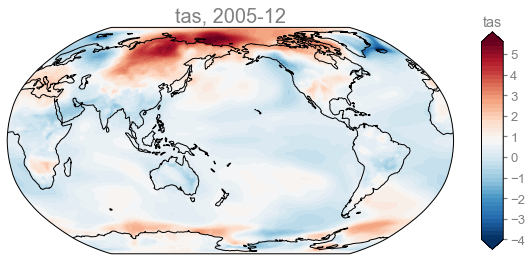

In [11]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
fig, ax = job.prior['tas'].plot(it=-1)

In [12]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...


<xarray.DataArray 'tas' (time: 1156, lat: 42, lon: 63)>
array([[[ 3.50997925e-01,  2.93665610e-01,  3.28684406e-01, ...,
          3.39764206e-01,  3.48886233e-01,  3.50997925e-01],
        [ 9.26483582e-01,  9.18037431e-01,  9.97301386e-01, ...,
          9.85246579e-01,  9.54159491e-01,  9.26483582e-01],
        [ 3.11964038e-01,  5.40504752e-01,  9.30123667e-01, ...,
          1.87633878e-01,  3.17730828e-01,  3.11964038e-01],
        ...,
        [-5.73252682e-01, -4.14780280e-01, -1.83932820e-01, ...,
         -7.05695091e-01, -7.09831750e-01, -5.73252682e-01],
        [-8.44291348e-01, -8.18824882e-01, -7.86828355e-01, ...,
         -7.95048135e-01, -8.31218609e-01, -8.44291348e-01],
        [-1.19067383e+00, -1.19899754e+00, -1.19923323e+00, ...,
         -1.18405519e+00, -1.18602448e+00, -1.19067383e+00]],

       [[ 1.17234550e-01,  6.23495891e-02,  9.40458230e-02, ...,
          1.02707604e-01,  1.14362244e-01,  1.17234550e-01],
        [-1.52815832e-01, -2.10093733e-01, -2.11417284e-01, ...,
          1.84683131e-02, -7.38368771e-02, -1.52815832e-01],
        [-2.08204014e-02, -1.04629322e-01, -1.57633638e-01, ...,
          1.84279648e-01,  2.04299561e-01, -2.08204014e-02],
...
        [-8.86050341e-01, -9.76015805e-01, -9.97395519e-01, ...,
         -5.67774524e-01, -7.35734160e-01, -8.86050341e-01],
        [-5.77959418e-01, -6.22154925e-01, -6.05618197e-01, ...,
         -4.06516483e-01, -4.84799899e-01, -5.77959418e-01],
        [ 2.44318638e-02,  2.62632479e-02,  2.62195634e-02, ...,
          3.35295060e-02,  2.77845733e-02,  2.44318638e-02]],

       [[ 8.57049286e-01,  8.52895183e-01,  8.41191944e-01, ...,
          8.39575983e-01,  8.49399827e-01,  8.57049286e-01],
        [ 2.99372849e-01,  3.34084352e-01,  3.72677423e-01, ...,
          2.92436565e-01,  3.30555435e-01,  2.99372849e-01],
        [-3.54235391e-01, -2.14225590e-01, -7.94867366e-02, ...,
         -2.81496947e-01, -2.75175575e-01, -3.54235391e-01],
        ...,
        [-9.94424978e-01, -9.87675297e-01, -7.83870006e-01, ...,
         -1.87150705e-01, -6.43495374e-01, -9.94424978e-01],
        [ 6.43866220e-01,  5.84103200e-01,  5.61185189e-01, ...,
          8.92312296e-01,  7.54542914e-01,  6.43866220e-01],
        [ 1.69565451e+00,  1.70823039e+00,  1.70603596e+00, ...,
          1.70048966e+00,  1.69468416e+00,  1.69565451e+00]]])
Coordinates:
  * time     (time) object 0850-12-31 00:00:00 ... 2005-12-31 00:00:00
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0

>>> job.configs["prior_lat_min"] = -20
>>> job.configs["prior_lat_max"] = 20
>>> job.configs["prior_lon_min"] = 150
>>> job.configs["prior_lon_max"] = 250
>>> Processing tas ...


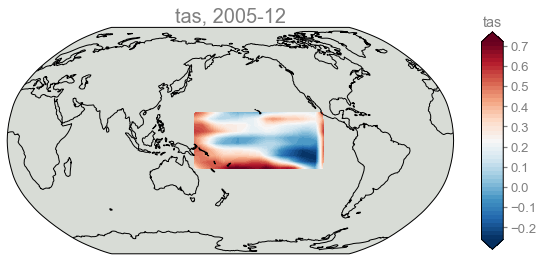

In [13]:
job.crop_clim(tag='prior', lat_min=-20, lat_max=20, lon_min=150, lon_max=250, verbose=True)
fig, ax = job.prior['tas'].plot(-1)

## Data assimilation

In [14]:
job.run_mc(save_dirpath='./results/ppe-pages2k', recon_seeds=[1, 2], verbose=True)

>>> job.configs["recon_period"] = [0, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./results/ppe-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 1}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 2001/2001 [00:13<00:00, 152.98it/s]


>>> Reconstructed fields saved to: ./results/ppe-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 2001/2001 [00:19<00:00, 101.62it/s]


>>> Reconstructed fields saved to: ./results/ppe-pages2k/job_r02_recon.nc
>>> DONE! Total time used: 0.60 mins.


## Validation

In [101]:
res = cfr.ReconRes('./results/ppe-pages2k', verbose=True)

>>> recon.paths:
['./results/ppe-pages2k/job_r01_recon.nc', './results/ppe-pages2k/job_r02_recon.nc']


In [102]:
res.load(['tas', 'tas_gm'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["tas_gm"] created
>>> ReconRes.da["tas_gm"] created


In [116]:
da = job.prior['tas'].geo_mean()
ref_time = [t.year for t in da.time.values]
ref_value = da.values
ref_name = 'truth'

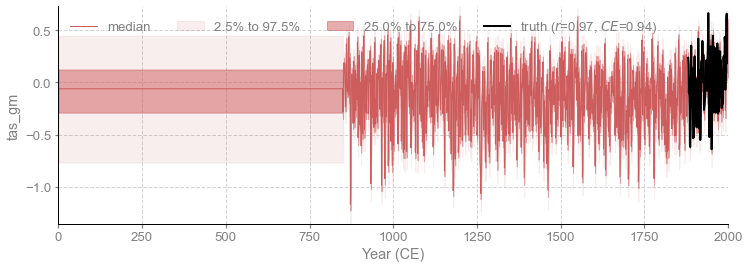

In [127]:
fig, ax = res.recons['tas_gm'].validate(ref_time, ref_value, ref_name).plot_qs()

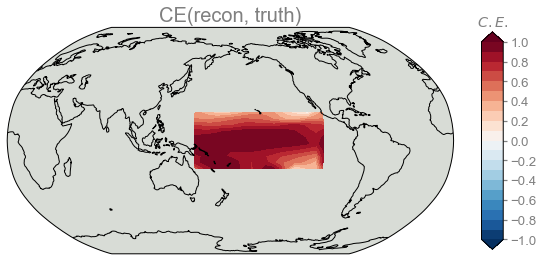

In [84]:
stat = 'CE'
valid_fd = res.recons['tas'].validate(job.prior['tas'], stat=stat)
fig, ax = valid_fd.plot(title=f'{stat}(recon, truth)', **valid_fd.plot_kwargs)